In [36]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
import numpy as np

In [14]:
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# stratify=y 層別サンプリング
# 引数に指定したデータのカテゴリ−比率を維持して標本を分割してくれる。
print(np.bincount(y))
print(np.bincount(y_train))
print(np.bincount(y_test))

[50 50 50]
[35 35 35]
[15 15 15]


In [21]:
sc = StandardScaler()

# 訓練データの平均と標準偏差を計算
sc.fit(X_train)

# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [23]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [25]:
y_pred = ppn.predict(X_test_std)
(y_test != y_pred).sum()

1

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9777777777777777

In [28]:
ppn.score(X_test_std, y_test)

0.9777777777777777

In [47]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y , classifier, test_idx=None, resolution = 0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max =  X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max =  X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl
                   )

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X[:, 0],
                    X[:, 1],
                    alpha=1.0,
                    c='none',
                    edgecolor='black',
                    marker='o',
                    label='test set'
                   )

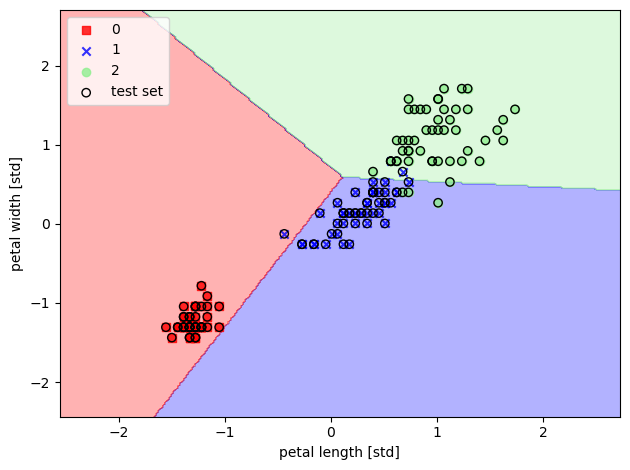

In [48]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105,150))
plt.xlabel('petal length [std]')
plt.ylabel('petal width [std]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

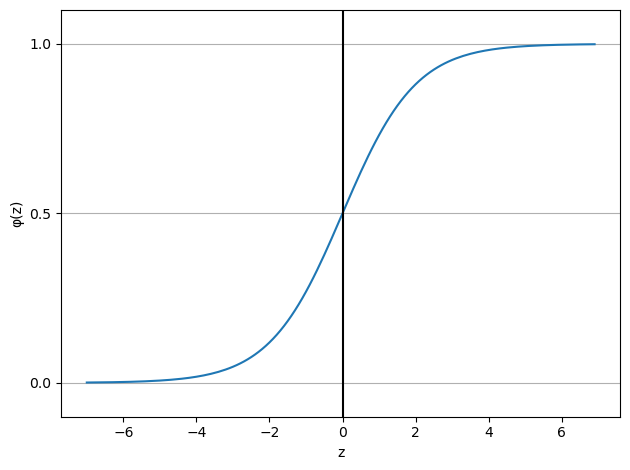

In [54]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('φ(z)')
plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

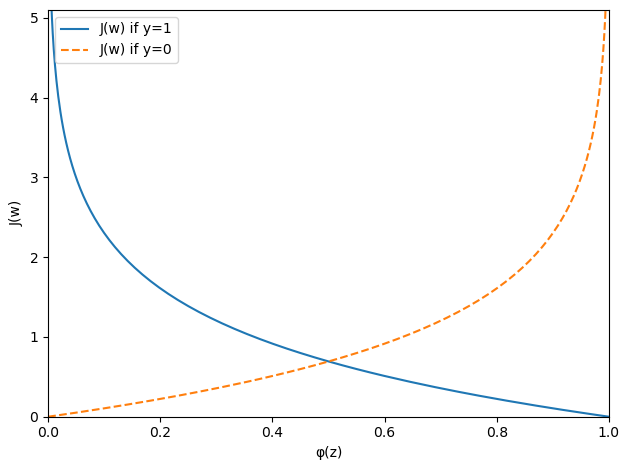

In [59]:
# 予測を間違えた場合は、誤差が大きいほどコストが高くなり、大きなペナルティを与えることになる
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('φ(z)')
plt.ylabel('J(w)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [79]:
from IPython.core.debugger import Pdb;

class LogisticRegressionGD(object):
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)

        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        # clip(z, 最小値, 最大値): 最小値、最大値の設定を行うメソッド。 zの要素で最小値を下回る値は最小値、最大値を上回る値は最大値に置き換える。
        return 1. / (1. + np.exp(-np.clip(z, -250,250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

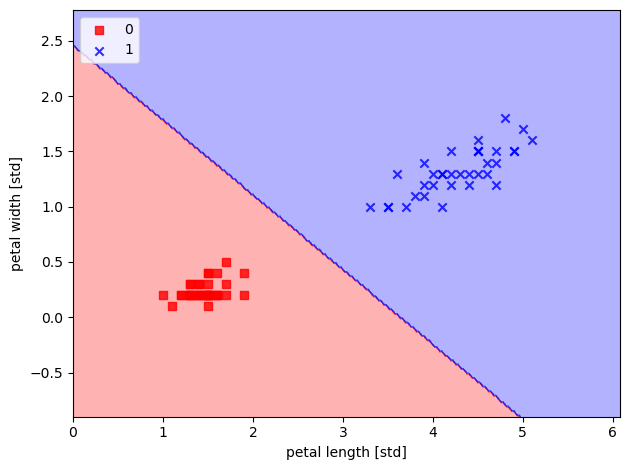

In [80]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length [std]')
plt.ylabel('petal width [std]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

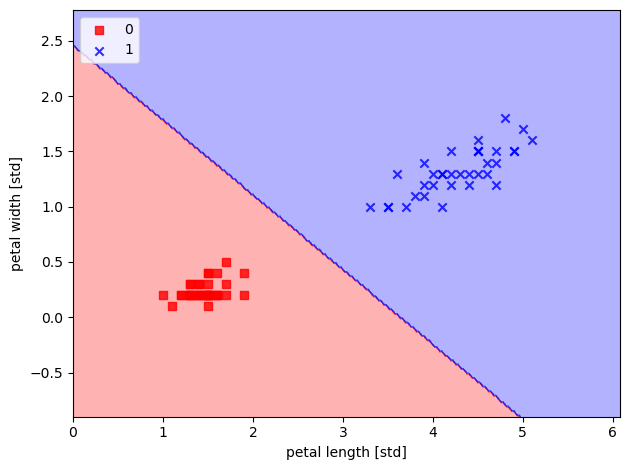

In [82]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs')
lr.fit(X_train_std, y_train)

plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length [std]')
plt.ylabel('petal width [std]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [93]:
lr.predict_proba(X_test_std[:3, :])

array([[9.37368464e-13, 3.91458193e-04, 9.99608542e-01],
       [9.93631074e-01, 6.36892585e-03, 1.20730798e-15],
       [9.98707332e-01, 1.29266792e-03, 1.82177043e-17]])

In [95]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [96]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

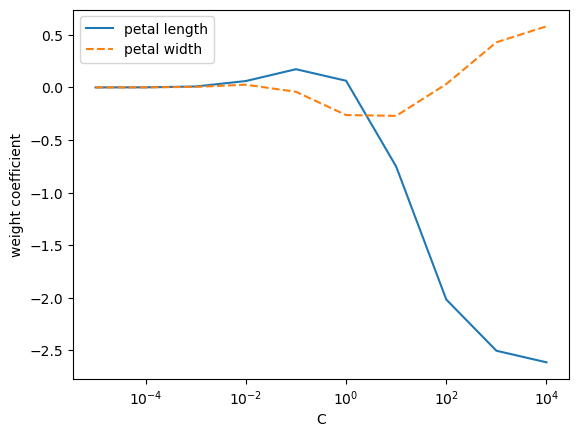

In [103]:
weights, params = [], []

for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, solver='lbfgs')
    lr.fit(X_train_std, y_train)

    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

plt.plot(params, weights[:,0], label='petal length')
plt.plot(params, weights[:,1], label='petal width', linestyle='--')
plt.xlabel('C')
plt.ylabel('weight coefficient')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()